#### **Generate Captions**

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pycocotools.coco import COCO
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from coco_dataloader import get_loader
from model import ResNetEncoder, RNNDecoder
from utils import clean_sentence, get_prediction

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Define a transform to pre-process the testing images
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.CenterCrop(224),                      # get 224x224 crop from the center
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Create the data loader
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Loaded pre-built vocab file


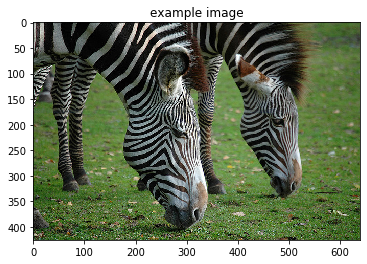

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


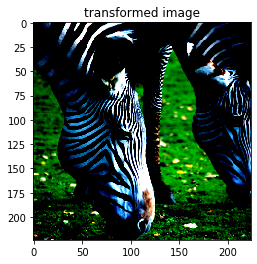

In [3]:
orig_image, image = next(iter(data_loader))
orig_img,img = orig_image.clone(),image.clone()
# Convert image from torch.FloatTensor to numpy ndarray
transformed_image = image.numpy()
# Remove the first dimension which is batch_size euqal to 1
transformed_image = np.squeeze(transformed_image)
transformed_image = transformed_image.transpose((1, 2, 0))

# Visualize sample image, before pre-processing
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()
# Visualize sample image, after pre-processing
plt.imshow(transformed_image)
plt.title('transformed image')
plt.show()

In [5]:
checkpoint = torch.load(os.path.join('./models', 'train-model-1-5100.pkl'))

# Specify values for embed_size and hidden_size - we use the same values as in training step
embed_size = 256
hidden_size = 512

# Get the vocabulary and its size
vocab = data_loader.dataset.vocab
vocab_size = len(vocab)

# Initialize the encoder and decoder, and set each to inference mode
encoder = ResNetEncoder(embed_size)
encoder.eval()
decoder = RNNDecoder(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the pre-trained weights
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

# Move models to GPU if CUDA is available.
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

In [6]:
# Obtain the embedded image features.
features = encoder(img).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.greedy_search(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.id2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 1835, 170, 77, 3, 204, 13, 136, 18, 1, 1, 1, 18, 1, 1, 1, 1, 1, 1]


In [7]:
sentence = clean_sentence(output, vocab)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a zebra standing in a field of grass .


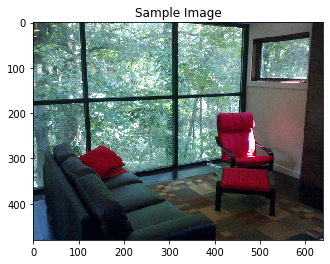

Caption without beam search:
a living room with a couch , chair , and a television .
Top captions using beam search:
a living room with a couch and a television .
a living room with a couch and a television .
a living room with a couch and a television .


In [8]:
get_prediction(data_loader, encoder, decoder, vocab)

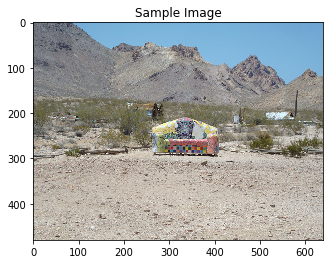

Caption without beam search:
a man is sitting on a bench in the rain .
Top captions using beam search:
a man sitting on the back of a boat .
a man sitting on the back of a boat .
a man sitting on the back of a boat .


In [9]:
get_prediction(data_loader, encoder, decoder, vocab)

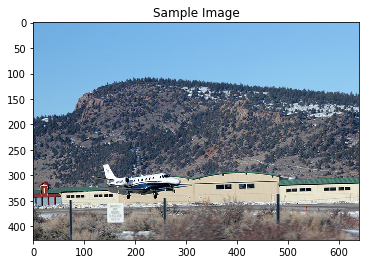

Caption without beam search:
a large jetliner sitting on top of a runway .
Top captions using beam search:
a large jetliner sitting on top of an airport tarmac .
a large jetliner sitting on top of an airport tarmac .
a large jetliner sitting on top of an airport tarmac .


In [10]:
get_prediction(data_loader, encoder, decoder, vocab)

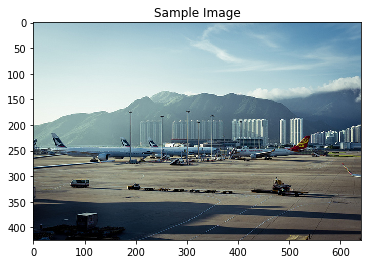

Caption without beam search:
a group of people standing on a train track .
Top captions using beam search:
a group of people standing on top of a sandy beach .
a group of people standing on top of a sandy beach .
a group of people standing on top of a sandy beach .


In [12]:
get_prediction(data_loader, encoder, decoder, vocab)

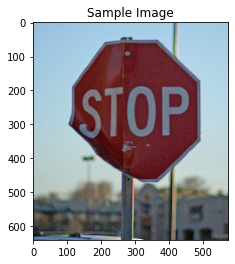

Caption without beam search:
a stop sign with a street sign and a stop sign .
Top captions using beam search:
a stop sign in front of a stop sign .
a stop sign in front of a stop sign .
a stop sign in front of a stop sign .


In [13]:
get_prediction(data_loader, encoder, decoder, vocab)

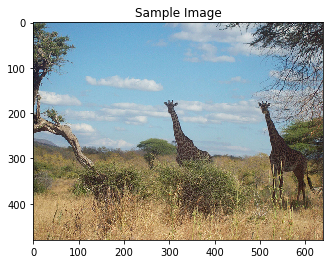

Caption without beam search:
a giraffe is standing in a field of tall grass .
Top captions using beam search:
a giraffe standing next to a tree in a field .
a giraffe standing next to a tree in a field .
a giraffe standing next to a tree in front of a tree .


In [14]:
get_prediction(data_loader, encoder, decoder, vocab)

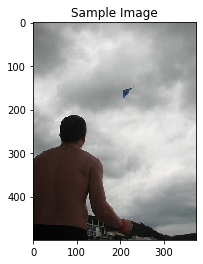

Caption without beam search:
a man in a blue shirt and a blue shirt and a kite .
Top captions using beam search:
a group of people flying kites in a field .
a group of people flying kites in a field .
a group of people flying kites in a field .


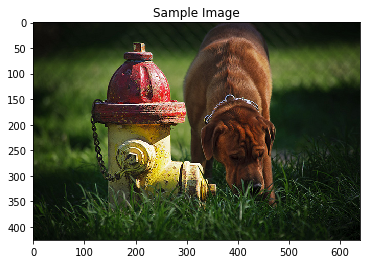

Caption without beam search:
a dog is standing in a field of grass .
Top captions using beam search:
a black and white dog is sitting in the grass .
a black and white dog is sitting in the grass .
a black and white dog is sitting in the grass .


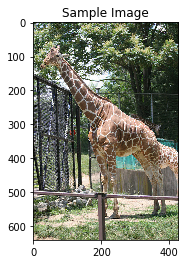

Caption without beam search:
a giraffe is standing in a field of grass .
Top captions using beam search:
a couple of giraffes that are standing in the dirt .
a couple of giraffes that are standing in the dirt .
a couple of giraffes that are standing in a field .


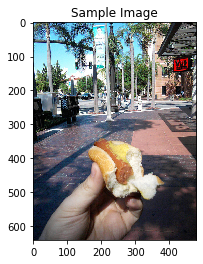

Caption without beam search:
a woman is holding a large hot dog .
Top captions using beam search:
a group of people riding bikes down a street .
a group of people riding bikes down a street .
a group of people riding bikes down a street .


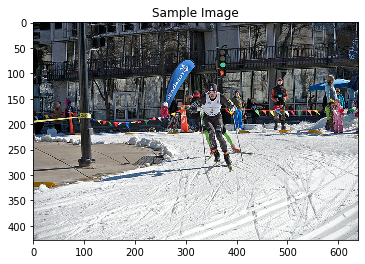

Caption without beam search:
a group of people skiing in the snow .
Top captions using beam search:
a group of people standing on top of a snow covered slope .
a group of people standing on top of a snow covered slope .
a group of people standing on top of a snow covered slope .


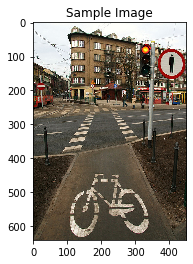

Caption without beam search:
a street with a bus and a sign on the side of it .
Top captions using beam search:
a parking meter on the side of a street .
a parking meter on the side of a street .
a parking meter on the side of a street .


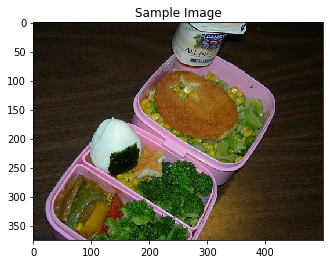

Caption without beam search:
a plate of food with a fork and a fork .
Top captions using beam search:
a close up of a plate of food on a table .
a close up of a plate of food on a table .
a close up of a plate of food on a table .


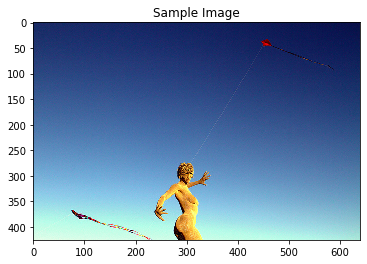

Caption without beam search:
a man in a white shirt and black shorts playing a game of frisbee .
Top captions using beam search:
a man flying a kite on a sunny day .
a man flying a kite on a sunny day .
a man flying a kite on a sunny day .


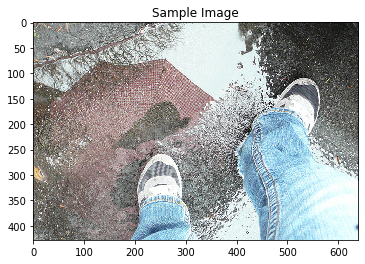

Caption without beam search:
a man is sitting on a toilet in a room .
Top captions using beam search:
a young boy is sitting on a skateboard .
a young boy is sitting on a skateboard .
a young boy is sitting on a skateboard .


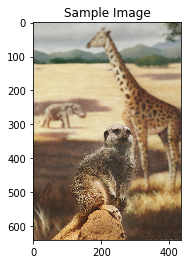

Caption without beam search:
a couple of ducks that are standing in the dirt .
Top captions using beam search:
a couple of ducks that are standing in the dirt .
a couple of ducks that are standing in the dirt .
a couple of ducks that are standing in the dirt .


In [15]:
for i in range(10):
    get_prediction(data_loader, encoder, decoder, vocab)

In [2]:
from vocabulary import Vocabulary

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
sample_vocab = Vocabulary(threshold=10,load_vocab=True,anns_file = "annotations/image_info_test2014.json")
    

Loaded pre-built vocab file


In [15]:
len(sample_vocab)

8856

TypeError: 'Vocabulary' object is not iterable